In [72]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [73]:
in_channels, out_channels = 5, 10
width, height = 100, 100
kernel_size = 3
batch_size = 128

In [74]:
input = torch.randn(batch_size, in_channels, width, height)
conv_layer = torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size)
out_put = conv_layer(input)

print(input.shape)
print(out_put.shape)
print(conv_layer.weight.shape)

torch.Size([128, 5, 100, 100])
torch.Size([128, 10, 98, 98])
torch.Size([10, 5, 3, 3])


In [75]:

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root="../dataset/", train=True, download=True, transform=transform)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

test_dataset = datasets.MNIST(root="../dataset/", train=False, download=True, transform=transform)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)


In [76]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(10, 20, kernel_size=5)
        self.pooling = torch.nn.MaxPool2d(2)
        self.fc = torch.nn.Linear(320, 10)

    def forward(self, x):
        batch_size = x.size(0)
        x = F.relu(self.pooling(self.conv1(x)))
        x = F.relu(self.pooling(self.conv2(x)))
        x = x.view(batch_size, -1)
        x = self.fc(x)

        return x

In [77]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [78]:
def train(epoch):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_dataloader, 0):
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if batch_idx % 300 == 299:
            print("[%d, %5d] loss: %.3f" %(epoch, batch_idx+1, running_loss/300))
            running_loss = 0.0

def test():
    correct = .0
    total = .0

    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return (correct/total)*100

[0,   300] loss: 1.128
accuracy on test set: 91%
[1,   300] loss: 0.253
accuracy on test set: 94%
[2,   300] loss: 0.176
accuracy on test set: 95%
[3,   300] loss: 0.141
accuracy on test set: 96%
[4,   300] loss: 0.119
accuracy on test set: 97%
[5,   300] loss: 0.107
accuracy on test set: 97%
[6,   300] loss: 0.099
accuracy on test set: 97%
[7,   300] loss: 0.090
accuracy on test set: 97%
[8,   300] loss: 0.082
accuracy on test set: 97%
[9,   300] loss: 0.079
accuracy on test set: 98%


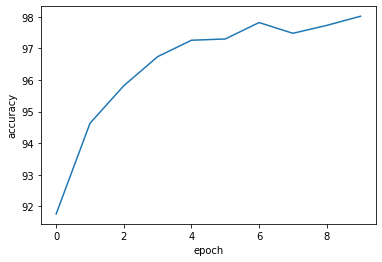

In [79]:
if __name__ == '__main__':
    epoch_list = []
    acc_list = []

    for epoch in range(10):
        train(epoch)
        acc = test()
        epoch_list.append(epoch)
        acc_list.append(acc)
        print("accuracy on test set: %d%%" %acc)


    plt.plot(epoch_list, acc_list)
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.show()
